In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Load your dataset (Replace with your actual file path)
df = pd.read_csv('/content/bitcoin.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# --- EDA Section ---
print("### Dataset Overview ###")
print(df.info())


### Dataset Overview ###
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1049 entries, 2017-01-01 to 2019-11-15
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1049 non-null   float64
 1   High       1049 non-null   float64
 2   Low        1049 non-null   float64
 3   Close      1049 non-null   float64
 4   Adj Close  1049 non-null   float64
 5   Volume     1049 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 57.4 KB
None


In [7]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [6]:
df.shape

(1049, 6)

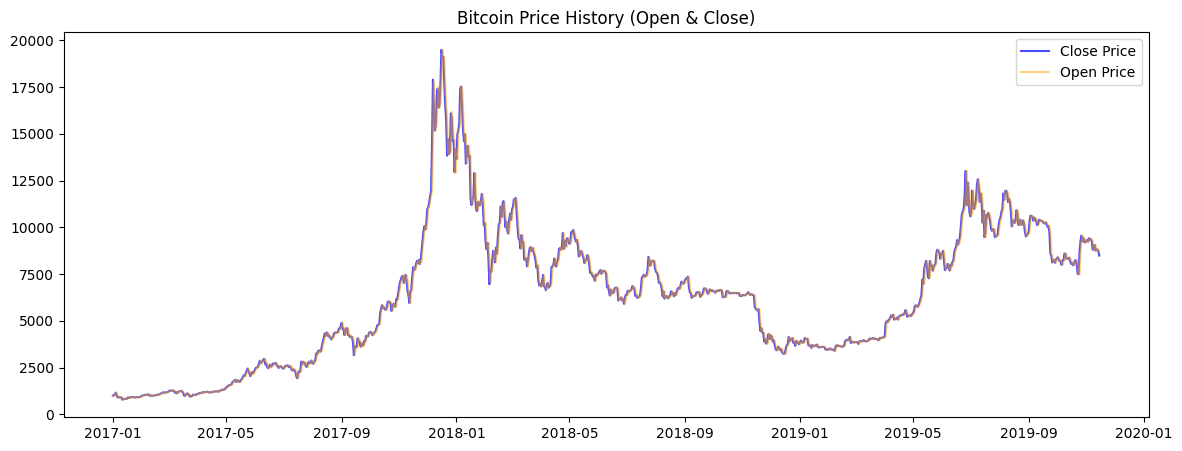

In [8]:
# Visualizing the Closing and Opening price trends
plt.figure(figsize=(14, 5))
plt.plot(df['Close'], label='Close Price', color='blue', alpha=0.7)
plt.plot(df['Open'], label='Open Price', color='orange', alpha=0.5)
plt.title('Bitcoin Price History (Open & Close)')
plt.legend()
plt.show()

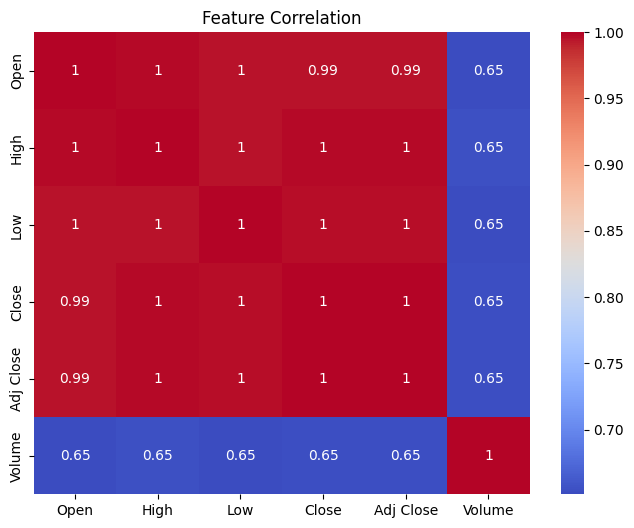

In [9]:
# Correlation Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation')
plt.show()

In [10]:
# 1. Feature Selection
# We use all available features as inputs
features = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
data = df[features].values

# 2. Train-Test Split (Chronological, NOT random)
train_size = int(len(data) * 0.8)
train_data = data[:train_size]
test_data = data[train_size:]

# 3. Standardization (Fit on Train, Transform Test to avoid leakage)
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_data)
test_scaled = scaler.transform(test_data)

# 4. Creating Sequences
def create_sequences(data, window_size=60):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i]) # Past 60 days
        # Output is index 0 (Open) and index 3 (Close)
        y.append([data[i, 0], data[i, 3]])
    return np.array(X), np.array(y)

window_size = 60
X_train, y_train = create_sequences(train_scaled, window_size)
X_test, y_test = create_sequences(test_scaled, window_size)

print(f"X_train shape: {X_train.shape}") # (samples, time_steps, features)
print(f"y_train shape: {y_train.shape}") # (samples, 2) -> Open and Close

X_train shape: (779, 60, 6)
y_train shape: (779, 2)


In [11]:
model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(units=50),
    Dropout(0.2),
    Dense(units=2) # Predicts 2 values: [Open, Close]
])

model.compile(optimizer='adam', loss='mean_squared_error')

# Training
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)


Epoch 1/30


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - loss: 0.4623 - val_loss: 0.0847
Epoch 2/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.1060 - val_loss: 0.0843
Epoch 3/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 0.0778 - val_loss: 0.0558
Epoch 4/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 0.0576 - val_loss: 0.0928
Epoch 5/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 0.0500 - val_loss: 0.0384
Epoch 6/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0355 - val_loss: 0.0442
Epoch 7/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0471 - val_loss: 0.0376
Epoch 8/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 0.0352 - val_loss: 0.0421
Epoch 9/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0309 - val_loss: 0.0370
Epoch 10/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 0.0303 - val_loss: 0.0367
Epoch 11/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.0258 - val_loss: 0.0613
Epoch 12/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0324 - val_l

In [12]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        11,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │           102 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 95,108 (371.52 KB)

 Trainable params: 31,702 (123.84 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 63,406 (247.68 KB)

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


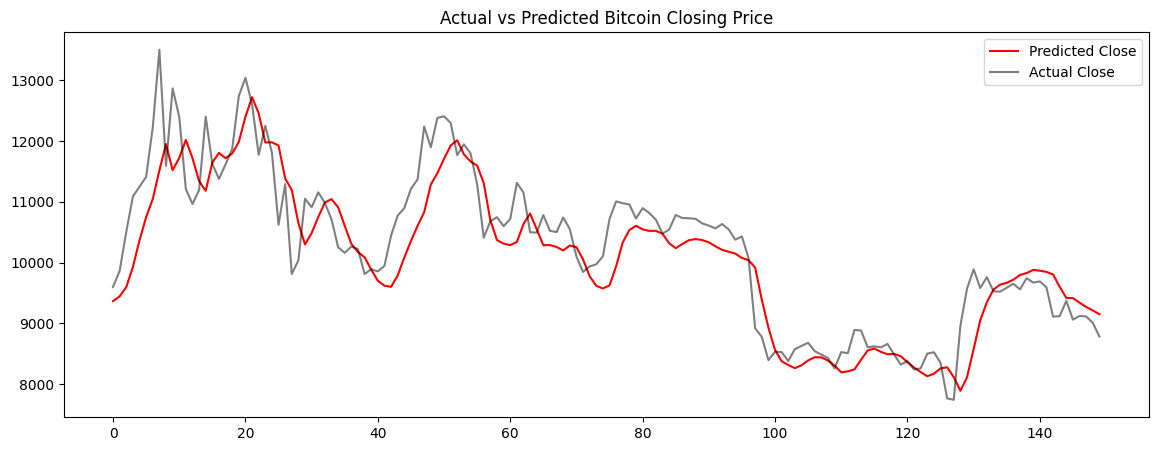

In [13]:
# Make predictions
predictions_scaled = model.predict(X_test)

# To inverse transform correctly, we need a dummy array matching the scaler's original input shape (6 features)
dummy_train = np.zeros((len(predictions_scaled), 6))
# Put predicted Open in index 0 and Close in index 3
dummy_train[:, 0] = predictions_scaled[:, 0]
dummy_train[:, 3] = predictions_scaled[:, 1]

# Inverse transform only the columns we need
final_predictions = scaler.inverse_transform(dummy_train)[:, [0, 3]]
actual_values = scaler.inverse_transform(np.concatenate([y_test, np.zeros((len(y_test), 4))], axis=1))[:, [0, 1]]

# Plotting Results
plt.figure(figsize=(14, 5))
plt.plot(final_predictions[:, 1], label='Predicted Close', color='red')
plt.plot(actual_values[:, 1], label='Actual Close', color='black', alpha=0.5)
plt.title('Actual vs Predicted Bitcoin Closing Price')
plt.legend()
plt.show()

In [14]:
# Assuming 'final_predictions' is the inverse-scaled array from the previous step
predicted_opens = final_predictions[:, 0]  # Extracts all rows, first column (Open)
predicted_closes = final_predictions[:, 1] # Extracts all rows, second column (Close)

# To see the predicted prices for the most recent day in your test set:
latest_open = predicted_opens[-1]
latest_close = predicted_closes[-1]

print(f"Predicted Opening Price for the next day: {latest_open:.2f}")
print(f"Predicted Closing Price for the next day: {latest_close:.2f}")

Predicted Opening Price for the next day: 9113.12
Predicted Closing Price for the next day: 9148.34


In [15]:
# Assuming df is your dataframe and 'Date' is a column or index
# If Date is the index, use df.index.values directly, no need to reset index if only accessing dates

# 1. Get the dates for the test portion
test_dates = df.index.values[train_size:]

# 2. Adjust dates to match the 'window'
# Because we start predicting after the first 60 days (window_size)
# The first prediction matches test_dates[60]
prediction_dates = test_dates[window_size:]

print(f"Total test dates: {len(test_dates)}")
print(f"Total prediction dates: {len(prediction_dates)}")

Total test dates: 210
Total prediction dates: 150


In [16]:
# Create the final comparison table
results_df = pd.DataFrame({
    'Date': prediction_dates,
    'Actual Open': actual_values[:, 0],
    'Predicted Open': final_predictions[:, 0],
    'Actual Close': actual_values[:, 1],
    'Predicted Close': final_predictions[:, 1]
})

# Format the Date column for better readability in Colab
results_df['Date'] = pd.to_datetime(results_df['Date']).dt.date

# Display the result
print("### Bitcoin Price Predictions with Dates ###")
display(results_df.head(10))

### Bitcoin Price Predictions with Dates ###


,Date,Actual Open,Predicted Open,Actual Close,Predicted Close
0,2019-06-19,9078.73,9384.624098,9597.864861,9365.173382
1,2019-06-20,9273.06,9458.558061,9862.696320,9443.888694
2,2019-06-21,9525.07,9618.129929,10507.338106,9596.196164
3,2019-06-22,10175.92,9969.890669,11089.050575,9926.703887
4,2019-06-23,10696.69,10459.410176,11249.511459,10368.227717
5,2019-06-24,10853.74,10843.916498,11412.112795,10748.079738
6,2019-06-25,11007.20,11131.389986,12226.341104,11046.454926
7,2019-06-26,11778.58,11620.450901,13505.715945,11518.257861
8,2019-06-27,13017.12,12141.888382,11591.399224,11950.988497
9,2019-06-28,11162.17,11702.926239,12869.949208,11521.026231


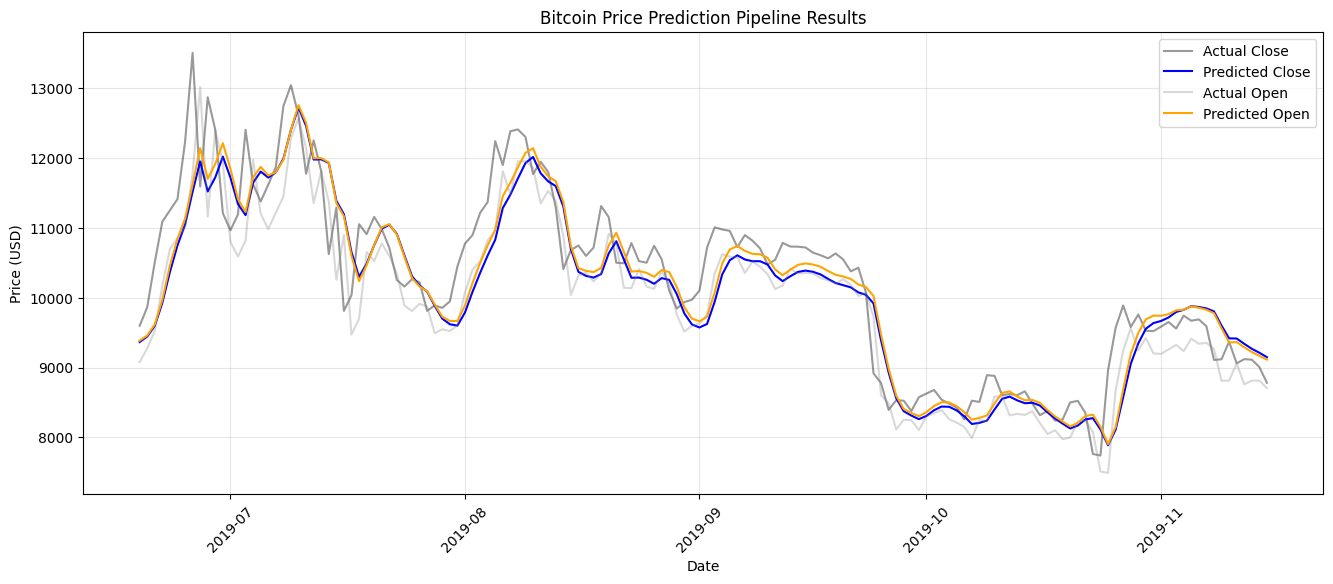

In [17]:
plt.figure(figsize=(16, 6))

# Plotting Closing Prices
plt.plot(results_df['Date'], results_df['Actual Close'], label='Actual Close', color='black', alpha=0.4)
plt.plot(results_df['Date'], results_df['Predicted Close'], label='Predicted Close', color='blue')

# Plotting Opening Prices
plt.plot(results_df['Date'], results_df['Actual Open'], label='Actual Open', color='gray', alpha=0.3)
plt.plot(results_df['Date'], results_df['Predicted Open'], label='Predicted Open', color='orange')

plt.title('Bitcoin Price Prediction Pipeline Results')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [18]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 1. Calculate Metrics for Opening Price
mae_open = mean_absolute_error(results_df['Actual Open'], results_df['Predicted Open'])
rmse_open = np.sqrt(mean_squared_error(results_df['Actual Open'], results_df['Predicted Open']))
r2_open = r2_score(results_df['Actual Open'], results_df['Predicted Open'])

# 2. Calculate Metrics for Closing Price
mae_close = mean_absolute_error(results_df['Actual Close'], results_df['Predicted Close'])
rmse_close = np.sqrt(mean_squared_error(results_df['Actual Close'], results_df['Predicted Close']))
r2_close = r2_score(results_df['Actual Close'], results_df['Predicted Close'])

# 3. Print the Accuracy Report
print("--------- MODEL ACCURACY REPORT ---------")
print(f"OPENING PRICE:")
print(f" - Mean Absolute Error (MAE): {mae_open:.2f}")
print(f" - Root Mean Squared Error (RMSE): {rmse_open:.2f}")
print(f" - R² Score: {r2_open:.4f}")
print("-" * 41)
print(f"CLOSING PRICE:")
print(f" - Mean Absolute Error (MAE): {mae_close:.2f}")
print(f" - Root Mean Squared Error (RMSE): {rmse_close:.2f}")
print(f" - R² Score: {r2_close:.4f}")

--------- MODEL ACCURACY REPORT ---------
OPENING PRICE:
 - Mean Absolute Error (MAE): 300.64
 - Root Mean Squared Error (RMSE): 378.43
 - R² Score: 0.9002
-----------------------------------------
CLOSING PRICE:
 - Mean Absolute Error (MAE): 426.75
 - Root Mean Squared Error (RMSE): 567.41
 - R² Score: 0.7957


In [19]:
mape_close = np.mean(np.abs((results_df['Actual Close'] - results_df['Predicted Close']) / results_df['Actual Close'])) * 100
print(f"The model is {100 - mape_close:.2f}% accurate on average.")

The model is 95.94% accurate on average.
